In [21]:
#@title Data retrieval
import os, requests, pdb

fname = []
for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)

In [22]:
#@title Import matplotlib and set defaults
from matplotlib import rcParams 
from matplotlib import pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [23]:
#@title Data loading
import numpy as np

alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat, np.load('steinmetz_part%d.npz'%j, allow_pickle=True)['dat']))

In [11]:
choice_areas = ["MOp", "MOs","PL", "SCm","ZI", "CP","SNr"]

In [24]:
def region_finder(region):
    # Find sessions with areas of interest
    session_idx = []
    neuron_idx = []
    for i in range(39):
        dat = alldat[i]
        areas = dat['brain_area']
        decision = areas==region
        if any(decision):
            n = [j for j, x in enumerate(decision) if x]
            session_idx.append(i)
            neuron_idx.append(n)
            #pdb.set_trace()
    return session_idx, neuron_idx

In [ ]:
def getChoiceCells(dat):
    #make array of choices. left choices = 1, right choices = 0, ignore no-go trials
    LorR = dat['response']!=0 
    choices = dat['response'][LorR]
    choices[choices == -1] = 0
    
    #turn dat['spks'] into [n_neurons, n_trials] array of normalized firing rates on each trial
    bins = 0.01 #10ms bins
    trial_FR = np.sum(dat['spks'], axis=2) / (np.shape(dat['spks'])[2] * bins / 1000)
    norm_FR = trial_FR[:,LorR] / np.mean(trial_FR) #array of normalized FR for each neuron in area on L or R choice trials (n_neurons x n_trials)
    
    # Define logistic regression model
    log_reg = LogisticRegression(penalty="none").fit(norm_FR.T, choices)
    y_pred = log_reg.predict(norm_FR.T)
    accuracy = (choices == y_pred).mean()
    
    most_predictive = np.quantile(log_reg.coef_, [0.10, 0.90])
    ispi_cells = log_reg.coef_ > most_predictive[1]
    contra_cells = log_reg.coef_ < most_predictive[0]
    
    return ispi_cells, contra_cells

def plot_weights(models, sharey=True):
    """Draw a stem plot of weights for each model in models dict."""
    n = len(models)
    f = plt.figure(figsize=(10, 2.5 * n))
    axs = f.subplots(n, sharex=True, sharey=sharey)
    axs = np.atleast_1d(axs)

    for ax, (title, model) in zip(axs, models.items()):

        ax.margins(x=.02)
        stem = ax.stem(model.coef_.squeeze(), use_line_collection=True)
        stem[0].set_marker(".")
        stem[0].set_color(".2")
        stem[1].set_linewidths(.5)
        stem[1].set_color(".2")
        stem[2].set_visible(False)
        ax.axhline(0, color="C3", lw=3)
        ax.set(ylabel="Weight", title=title)
    ax.set(xlabel="Neuron (a.k.a. feature)")
    f.tight_layout()

dict_keys(['spks', 'wheel', 'pupil', 'response', 'response_time', 'bin_size', 'stim_onset', 'contrast_right', 'contrast_left', 'brain_area', 'feedback_time', 'feedback_type', 'gocue', 'mouse_name', 'date_exp', 'trough_to_peak', 'active_trials', 'contrast_left_passive', 'contrast_right_passive', 'spks_passive', 'pupil_passive', 'wheel_passive', 'prev_reward', 'ccf', 'ccf_axes', 'cellid_orig', 'reaction_time', 'face', 'face_passive', 'licks', 'licks_passive'])


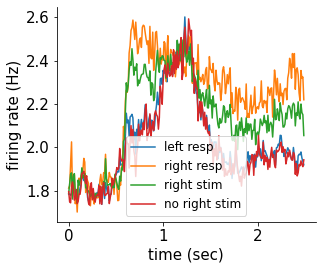

In [5]:
session_idx, neuron_idx = region_finder("MOs")
dat = alldat[session_idx[1]]
print(dat.keys())

dt = dat['bin_size'] # binning at 10 ms
zebras = dat['spks']
zebras = zebras[neuron_idx[1]]
NT = zebras.shape[-1]
ax = plt.subplot(1,5,1)
response = dat['response'] # right - nogo - left (-1, 0, 1)
vis_right = dat['contrast_right'] # 0 - low - high
vis_left = dat['contrast_left'] # 0 - low - high
plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:,response>=0].mean(axis=(0,1))) # left responses
plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:,response<0].mean(axis=(0,1))) # right responses
plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:,vis_right>0].mean(axis=(0,1))) # stimulus on the right
plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:,vis_right==0].mean(axis=(0,1))) # no stimulus on the right

plt.legend(['left resp', 'right resp', 'right stim', 'no right stim'], fontsize=12)
ax.set(xlabel  = 'time (sec)', ylabel = 'firing rate (Hz)');